## Testing with param

Providing `model` parameters and name, running simulation to produce energy deposition vs. time plot.

In [2]:
%env ASTERIA=/home/jakob/software/ASTERIA/ASTERIA
from asteria.simulation import Simulation
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

env: ASTERIA=/home/jakob/software/ASTERIA/ASTERIA


/usr/local/lib/python3.8/dist-packages/tqdm-4.65.0-py3.8.egg/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def moving_average(a, n=3, zero_padding = False, const_padding = False):
    if n%2 != 1:
        raise ValueError(f"n must be an uneven number but is {n}")
    if zero_padding:
        ind = np.arange(n-1)
        a = np.insert(a, ind, np.zeros(n-1))
        a = np.roll(a, -int((n-1)/2))
    if const_padding:
        ind1 = np.arange((n-1)/2).astype(int)
        ind2 = -np.arange(1,(n-1)/2+1).astype(int)
        a = np.insert(a, ind1, np.ones(int((n-1)/2))*a[0])
        a = np.insert(a, ind2, np.ones(int((n-1)/2))*a[-1])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
def min_max_in_window(a, window, return_index = False):
    xmin, xmax = 0,0
    arg_min, arg_max = 0,0
    for i in np.arange(len(a)-window+1):
        interval = a[i:i+window]
        tmin = interval.min() #temporary min
        tmax = interval.max() #temporary max
        t_argmin = np.argmin(interval)+i
        t_argmax = np.argmax(interval)+i
        if (tmax-tmin > xmax-xmin): 
            xmin, xmax = tmin, tmax
            arg_min, arg_max = t_argmin, t_argmax
    if return_index:
        return xmax-xmin, arg_min, arg_max
    else:
        return xmax-xmin

In [89]:
dt = 1*u.ms # highest frequency in Tamborra 2014 model

model = {'name': 'Tamborra_2014',
         'param':{
             'progenitor_mass': 27*u.Msun}
         }
sim = Simulation(model=model,
                 distance=10* u.kpc, 
                 Emin=0*u.MeV, Emax=100*u.MeV, dE=1*u.MeV,
                 tmin=0*u.s, tmax=0.55*u.s, dt=dt,
                 hierarchy = 'normal',
                 mixing_scheme = 'NoTransformation',
                 geomscope = 'Gen2')
sim.run()

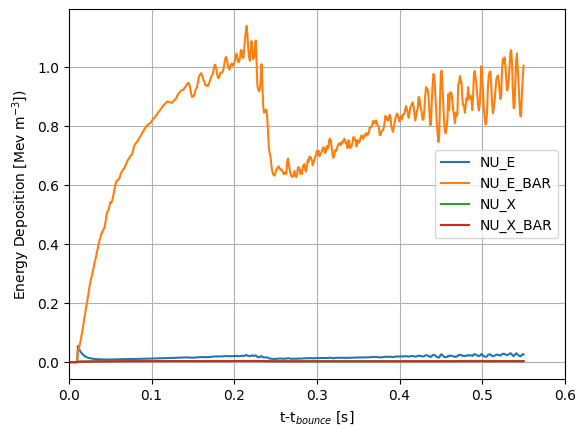

In [90]:
for flavor in sim.flavors:
    plt.plot(sim.time, sim.E_per_V[flavor], label=flavor.name)
plt.legend()
ax = plt.gca()
ax.set(xlabel=r't-t$_{bounce}$ [s]', ylabel='Energy Deposition [Mev m$^{-3}$])', xlim=(0, 0.6))
ax.grid()

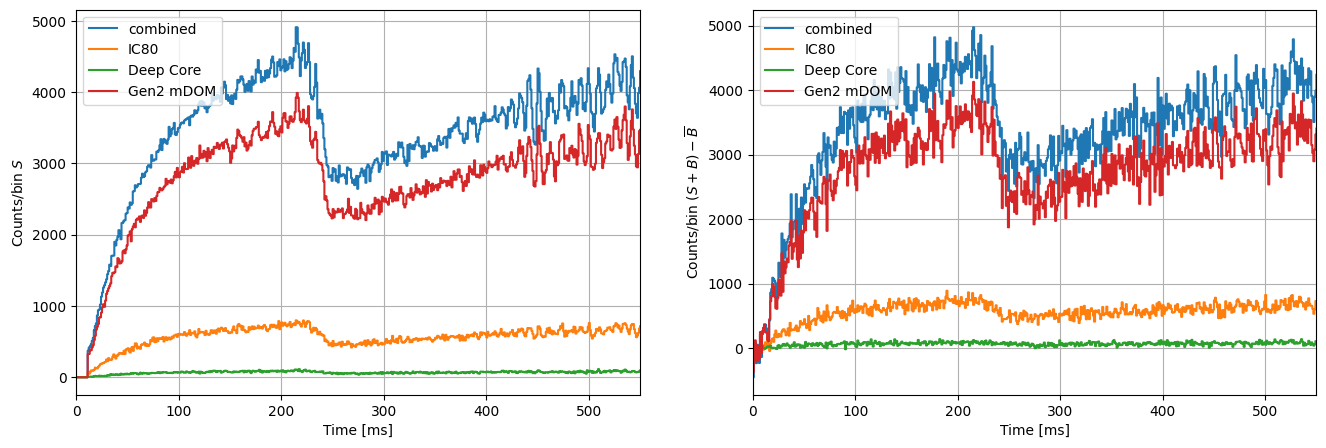

In [101]:
dt = 1*u.ms
sim.scale_result(distance=10*u.kpc)

t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
comb_bkg = i3_bkg + dc_bkg + md_bkg

i3 = i3_sig+i3_bkg
dc = dc_sig+dc_bkg
md = md_sig+md_bkg
comb = comb_sig+comb_bkg

fig, ax = plt.subplots(1,2, figsize=(16,5))
for i in range(2):
    if i == 0:
        ax[i].step(t, comb_sig, where='post', label='combined')
        ax[i].step(t, i3_sig, where='post', label='IC80')
        ax[i].step(t, dc_sig, where='post', label='Deep Core')
        ax[i].step(t, md_sig, where='post', label='Gen2 mDOM')
        ax[i].set_ylabel(r"Counts/bin $S$")

    elif i == 1:    
        ax[i].step(t, comb-comb_bkg.mean(), where='post', label='combined')
        ax[i].step(t, i3-i3_bkg.mean(), where='post', label='IC80')
        ax[i].step(t, dc-dc_bkg.mean(), where='post', label='Deep Core')
        ax[i].step(t, md-md_bkg.mean(), where='post', label='Gen2 mDOM')
        ax[i].set_ylabel(r"Counts/bin $(S+B)-\overline{B}$")

    ax[i].set_xlabel("Time [ms]")
    ax[i].set_xlim(0,550)
    ax[i].legend()
    ax[i].grid()

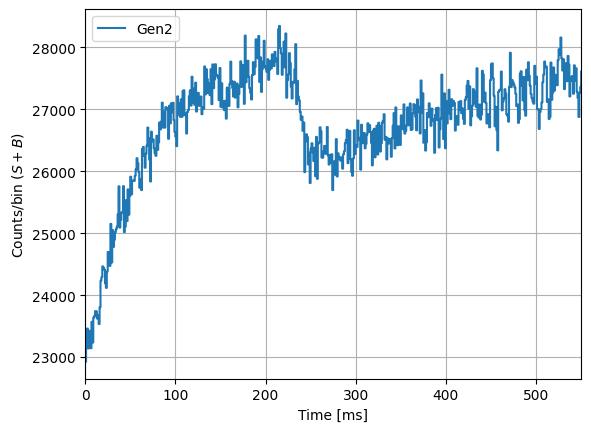

In [102]:
dt = 1*u.ms
fig, ax = plt.subplots(1,1)
ax.step(t, comb, where='post', label='Gen2')
ax.set_ylabel(r"Counts/bin $(S+B)$")
ax.set_xlabel("Time [ms]")
ax.set_xlim(0,550)
ax.legend()
ax.grid()

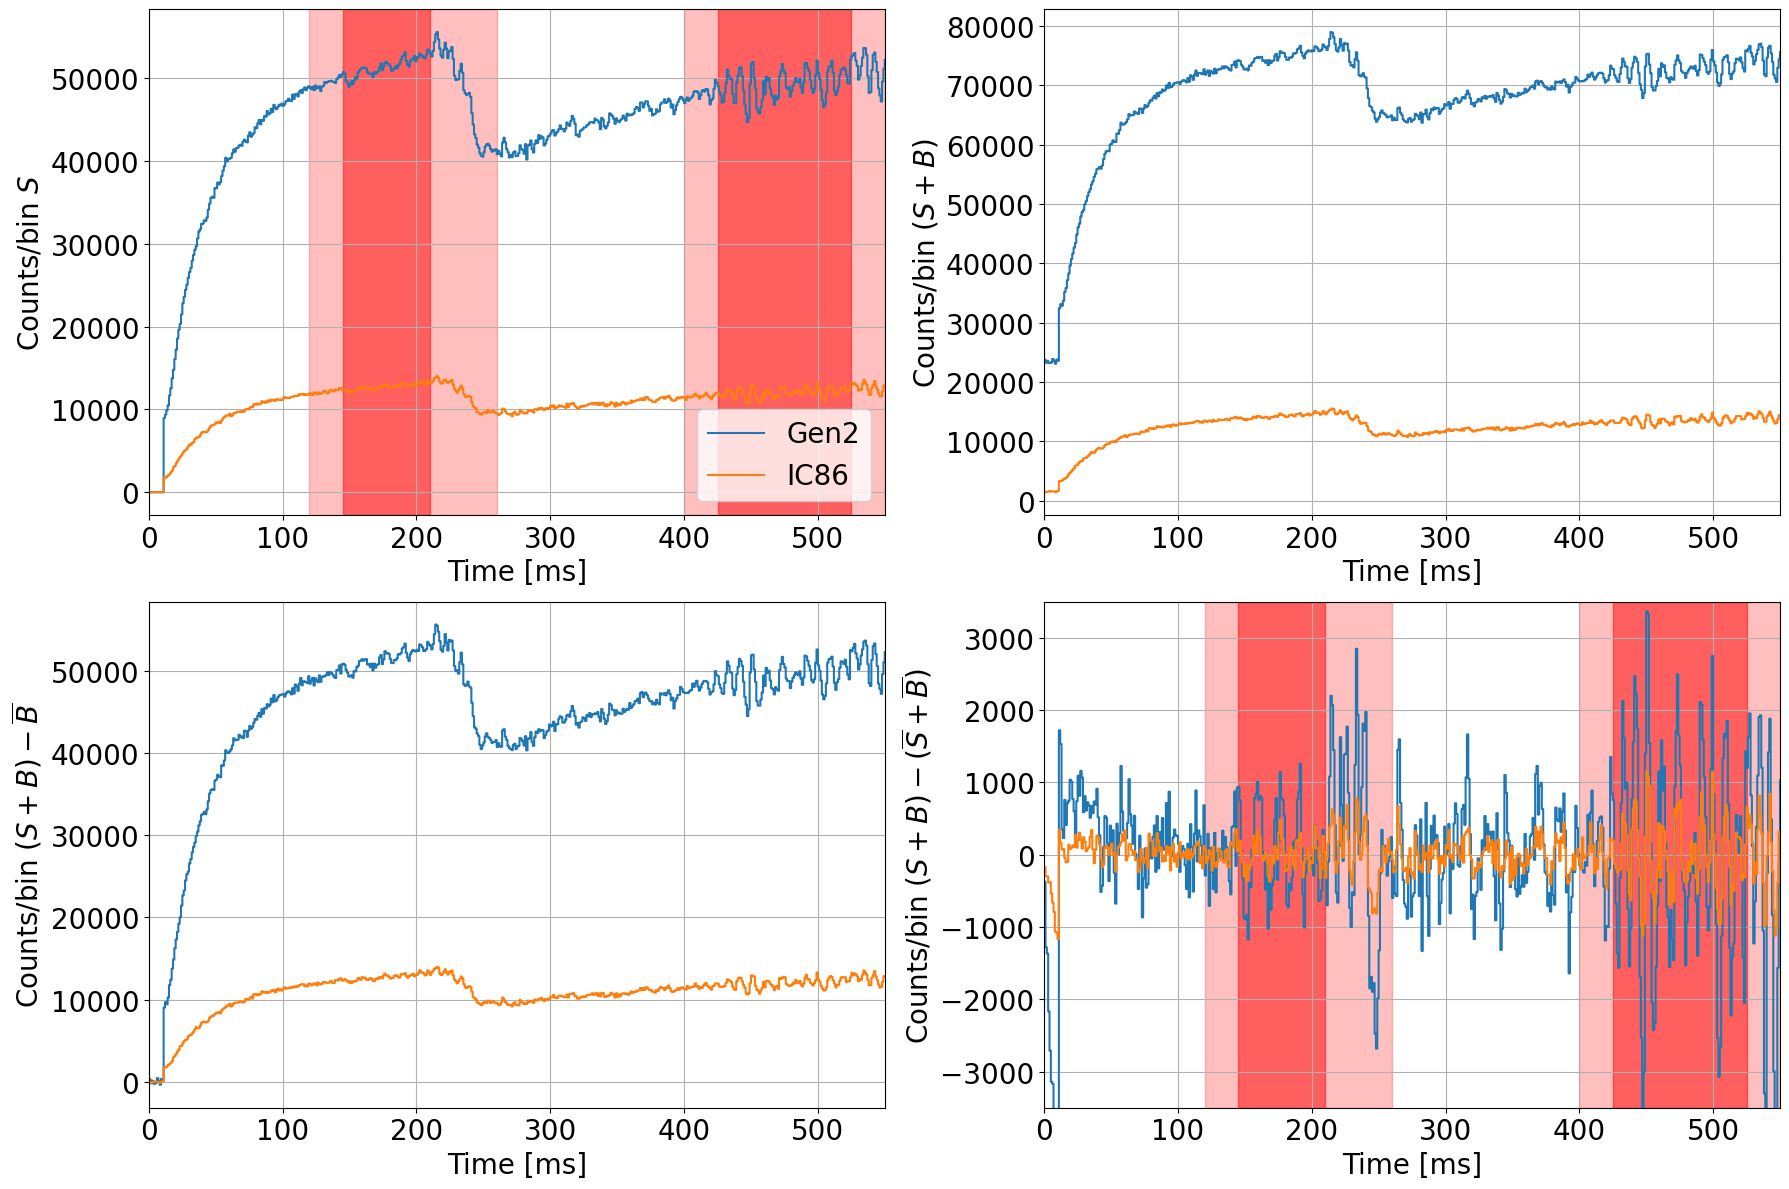

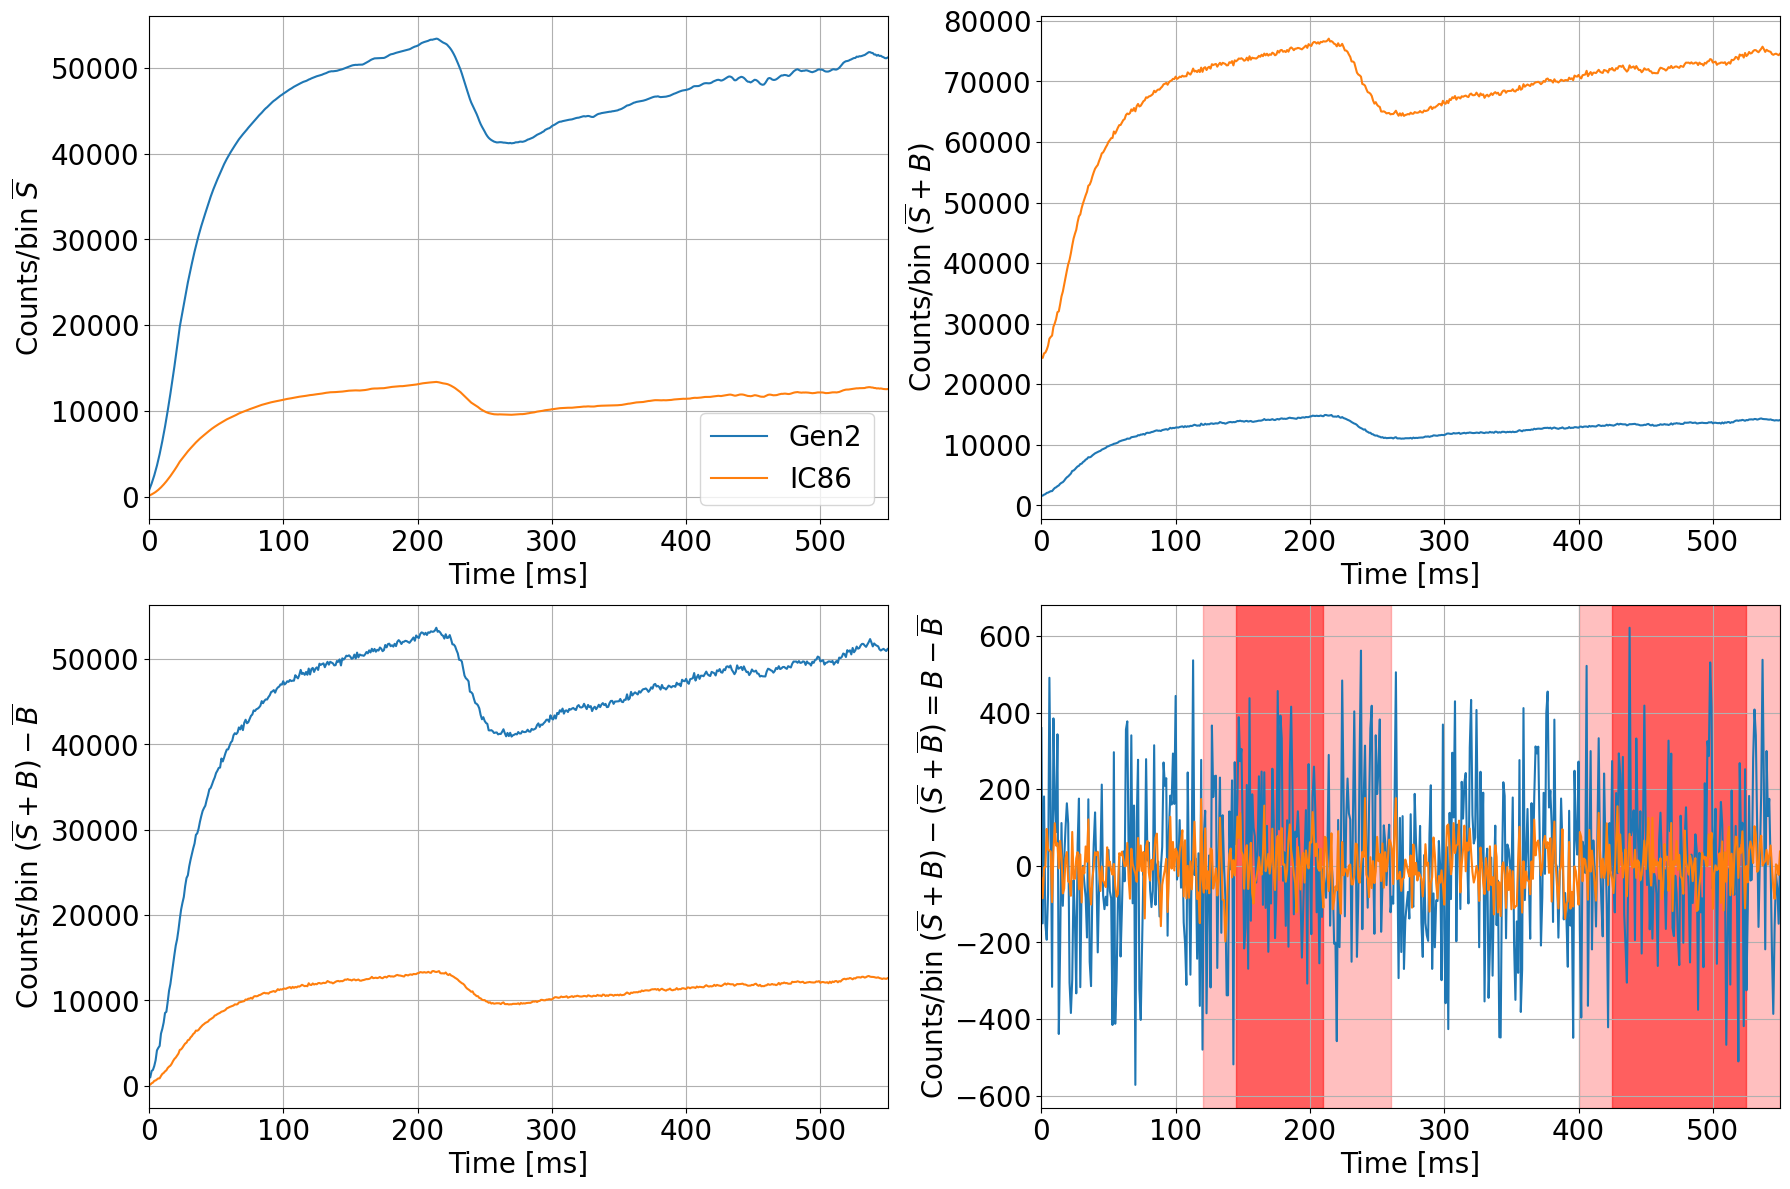

In [97]:
dt = 1*u.ms
bw = 25

sim.scale_result(distance=2*u.kpc)

# time and signal for each detector component [counts/bin]
t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

# random background realization
i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
comb_bkg = i3_bkg + dc_bkg + md_bkg


sig_ic86 = i3_sig + dc_sig
sig_gen2 = comb_sig
bkg_ic86 = i3_bkg + dc_bkg
bkg_gen2 = comb_bkg

# combined signal + background counts
ic86 = sig_ic86 + bkg_ic86
gen2 = sig_gen2 + bkg_gen2

# moving average sig with bw binning size and constant padding
sig_avg_ic86 = moving_average(sig_ic86, n=bw, const_padding=True)
sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)

# moving average sig + bkg
avg_ic86 = sig_avg_ic86 + bkg_ic86
avg_gen2 = sig_avg_gen2 + bkg_gen2

# average background rate given by the mean of the sensor distribution and scaled to the full detector
bkg_avg_ic86 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu)*dt/(1*u.s)
bkg_avg_gen2 = (sim.detector.n_i3_doms*sim.detector.i3_dom_bg_mu + sim.detector.n_dc_doms*sim.detector.dc_dom_bg_mu + sim.detector.n_md*sim.detector.md_bg_mu)*dt/(1*u.s)

# deviation between the moving average and the combined (sig+bkg) hit rate
dev_ic86 = ic86-sig_avg_ic86-bkg_avg_ic86
dev_gen2 = gen2-sig_avg_gen2-bkg_avg_gen2

# SASI signal
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].step(t, sig_gen2, where='post', label='Gen2')
ax[0].step(t, sig_ic86, where='post', label='IC86')
#ax[0].plot(t, sig_avg_gen2, ls = '-', color = 'red')
ax[0].axvspan(120,260,color = 'red', alpha = 0.25)
ax[0].axvspan(400,550,color = 'red', alpha = 0.25)
ax[0].axvspan(145,210,color = 'red', alpha = 0.5)
ax[0].axvspan(425,525,color = 'red', alpha = 0.5)
ax[1].step(t, gen2, where='post')
ax[1].step(t, ic86, where='post')
ax[2].step(t, gen2-bkg_avg_gen2, where='post')
ax[2].step(t, ic86-bkg_avg_ic86, where='post')
ax[3].step(t, dev_gen2, where='post')
ax[3].step(t, dev_ic86, where='post')
ax[3].axvspan(120,260,color = 'red', alpha = 0.25)
ax[3].axvspan(400,550,color = 'red', alpha = 0.25)
ax[3].axvspan(145,210,color = 'red', alpha = 0.5)
ax[3].axvspan(425,525,color = 'red', alpha = 0.5)
ax[3].set_ylim((-3500,3500))
for i in range(4):
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,550))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
ax[0].set_ylabel(r"Counts/bin $S$", fontsize = 20)
ax[1].set_ylabel(r"Counts/bin $(S+B)$", fontsize = 20)
ax[2].set_ylabel(r"Counts/bin $(S+B)-\overline{B}$", fontsize = 20)
ax[3].set_ylabel(r"Counts/bin $(S+B)-(\overline{S}+\overline{B})$", fontsize = 20)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt.show()

# flat signal (SASI wiggles averaged out)
fig, ax = plt.subplots(2,2, figsize=(18,12))
ax = ax.ravel()
ax[0].plot(t, sig_avg_gen2, ls = '-', color = 'C0', label='Gen2')
ax[0].plot(t, sig_avg_ic86, ls = '-', color = 'C1', label='IC86')
ax[1].plot(t, avg_ic86, ls = '-', color = 'C0')
ax[1].plot(t, avg_gen2, ls = '-', color = 'C1')
ax[2].plot(t, avg_gen2-bkg_avg_gen2, ls = '-', color = 'C0')
ax[2].plot(t, avg_ic86-bkg_avg_ic86, ls = '-', color = 'C1')
ax[3].plot(t, bkg_gen2-bkg_avg_gen2, ls = '-', color = 'C0')
ax[3].plot(t, bkg_ic86-bkg_avg_ic86, ls = '-', color = 'C1')
ax[3].axvspan(120,260,color = 'red', alpha = 0.25)
ax[3].axvspan(400,550,color = 'red', alpha = 0.25)
ax[3].axvspan(145,210,color = 'red', alpha = 0.5)
ax[3].axvspan(425,525,color = 'red', alpha = 0.5)
for i in range(4):
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_xlim((0,550))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
ax[0].set_ylabel(r"Counts/bin $\overline{S}$", fontsize = 20)
ax[1].set_ylabel(r"Counts/bin $(\overline{S}+B)$", fontsize = 20)
ax[2].set_ylabel(r"Counts/bin $(\overline{S}+B)-\overline{B}$", fontsize = 20)
ax[3].set_ylabel(r"Counts/bin $(\overline{S}+B)-(\overline{S}+\overline{B})=B-\overline{B}$", fontsize = 20)
ax[0].legend(fontsize = 20)
plt.tight_layout()
plt.show()




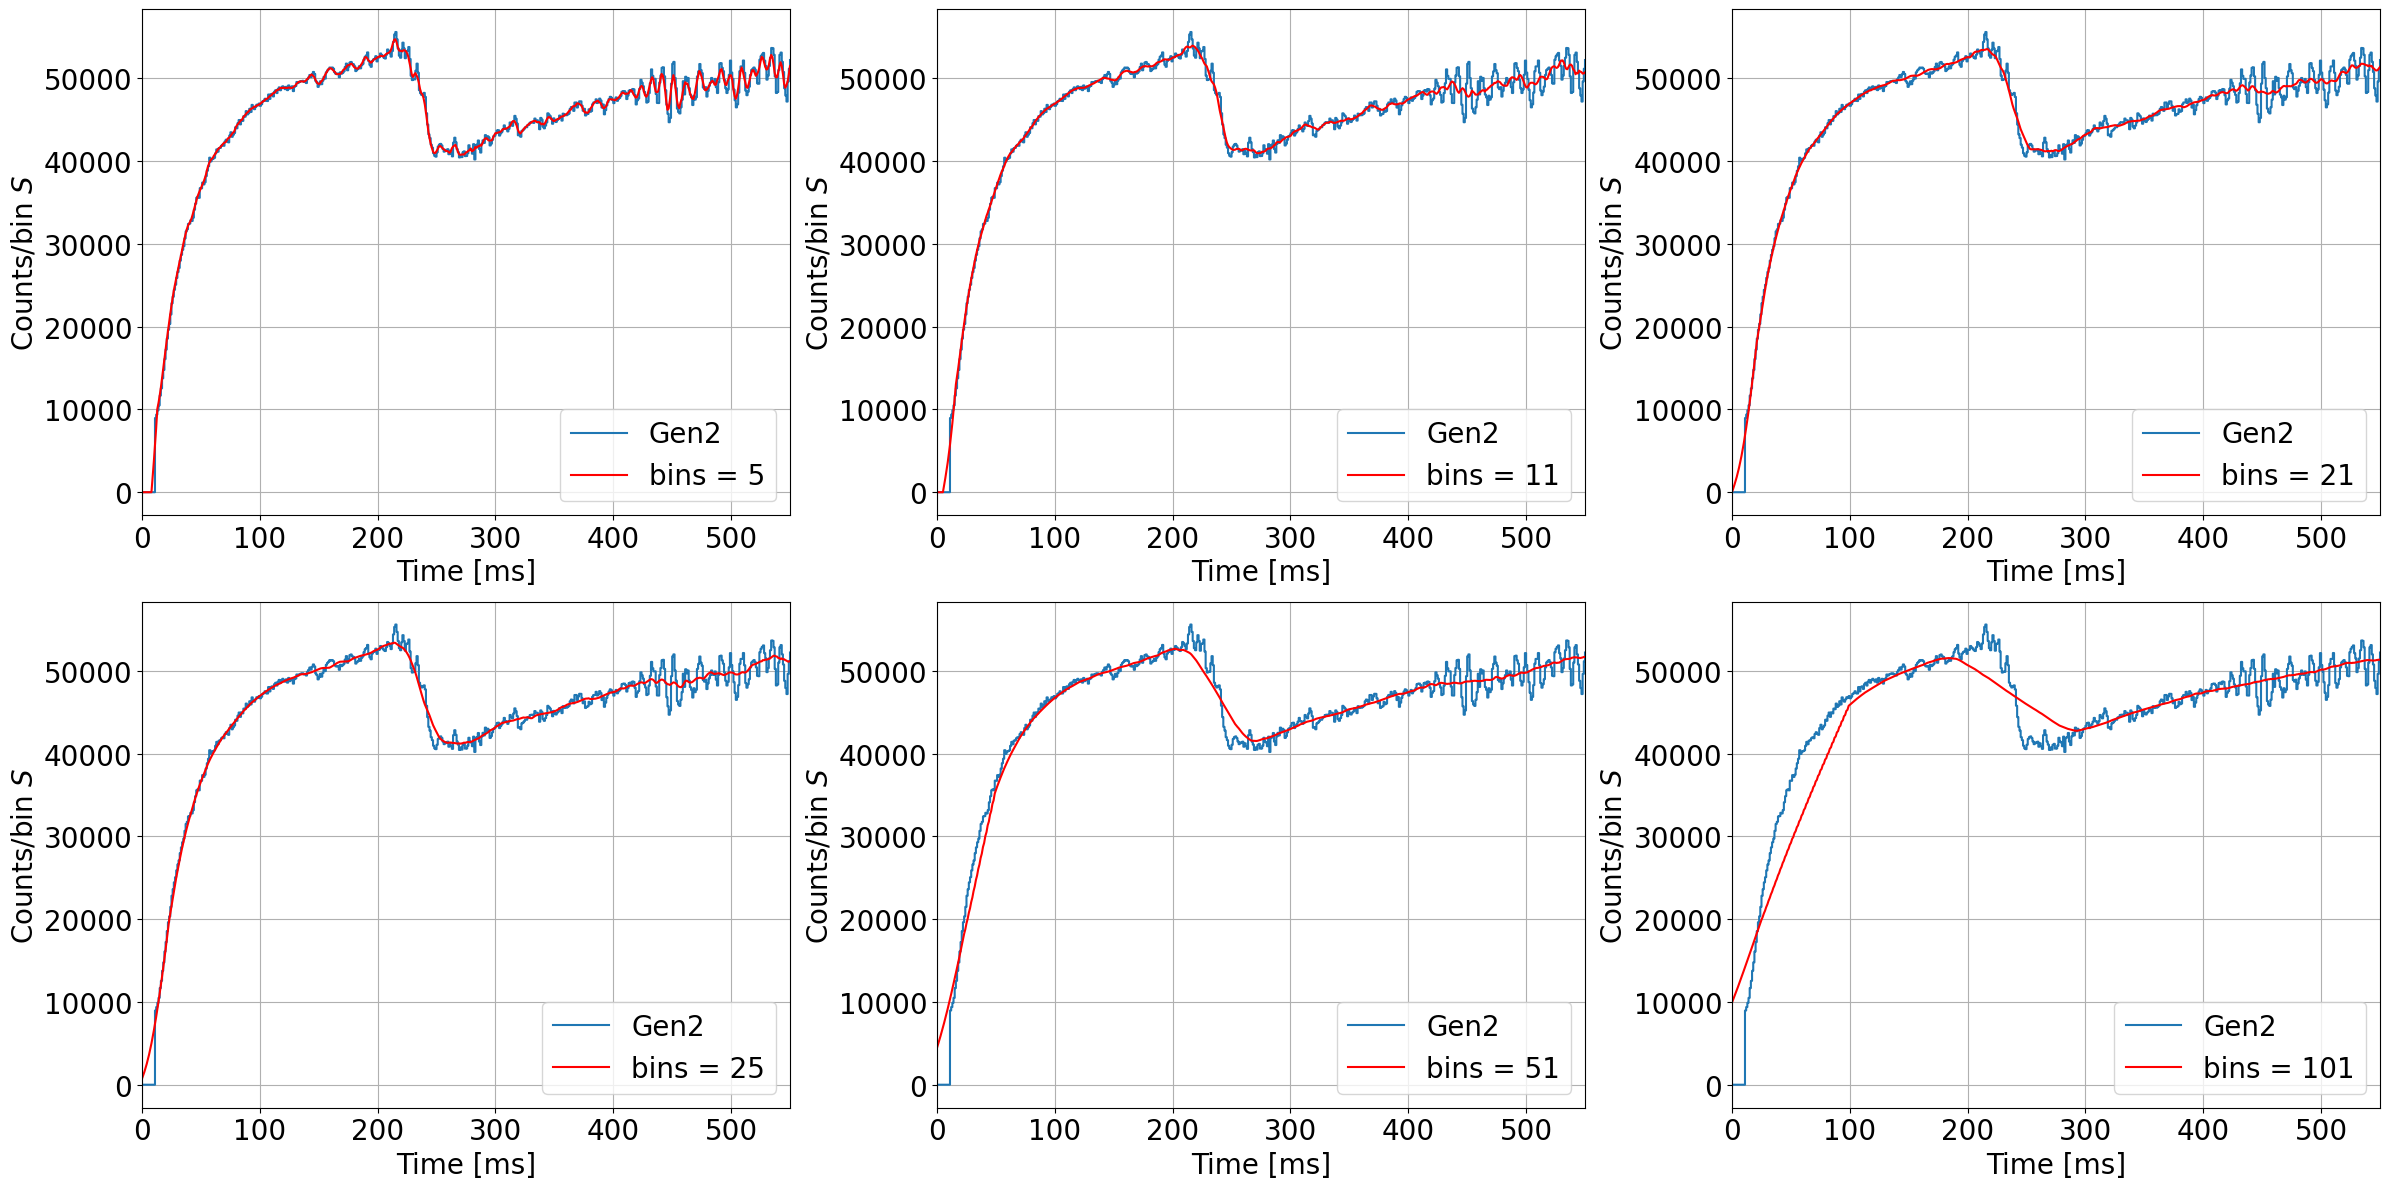

In [99]:
bw_range = np.array([5,11,21,25,51,101])
fig, ax = plt.subplots(2,3, figsize=(24,12))
ax = ax.ravel()

for i, bw in enumerate(bw_range):
    sig_avg_gen2 = moving_average(sig_gen2, n=bw, const_padding=True)
    ax[i].step(t, sig_gen2, where='post', label = 'Gen2')
    ax[i].plot(t, sig_avg_gen2, color = 'red', label='bins = {:.0f}'.format(bw))
    ax[i].set_xlabel("Time [ms]", fontsize = 20)
    ax[i].set_ylabel(r"Counts/bin $S$", fontsize = 20)
    ax[i].set_xlim((0,550))
    ax[i].grid()
    ax[i].tick_params(labelsize = 20)
    ax[i].legend(fontsize = 20)
plt.tight_layout()
plt.show()


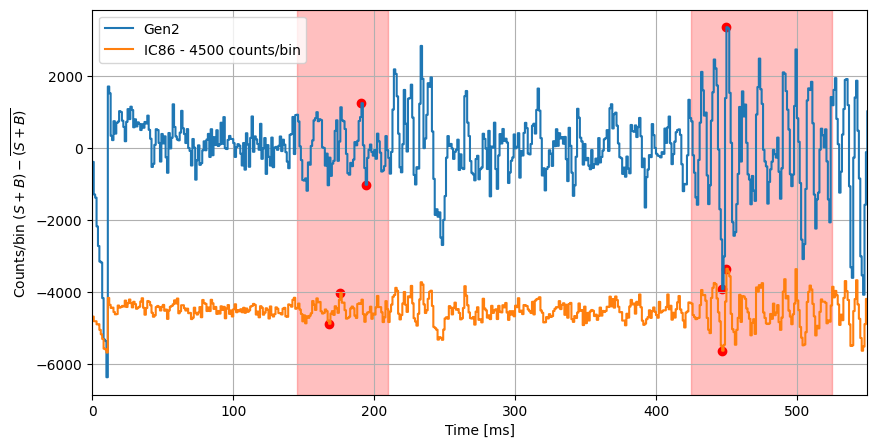

In [143]:
mw = 10
sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms

fig, ax = plt.subplots(1,1, figsize=(10,5))  

for i in range(2):
    if i == 0:
        dev = dev_gen2
        label = 'Gen2'
    elif i == 1:
        dev = dev_ic86 - 4500
        label = 'IC86 - 4500 counts/bin'
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"Counts/bin $(S+B)-\overline{(S+B)}$")
ax.set_xlim(0,550)
ax.legend()
ax.grid()

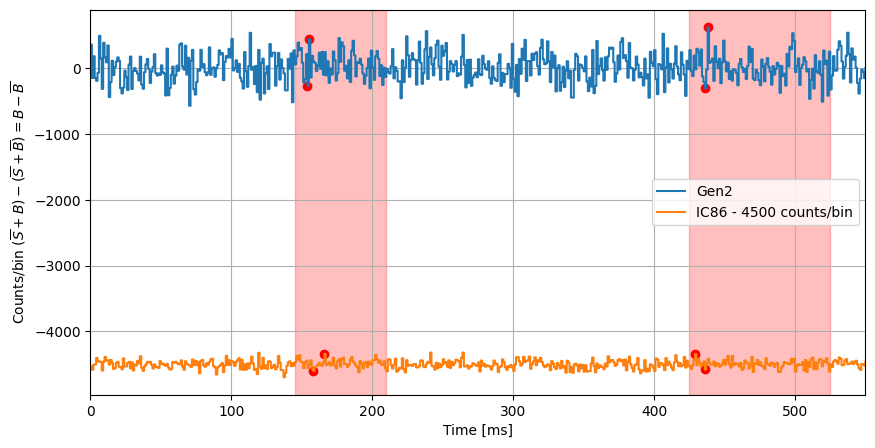

In [142]:
mw = 10
sasi1 = [145, 210] * u.ms
sasi2 = [425, 525] * u.ms

fig, ax = plt.subplots(1,1, figsize=(10,5))  

for i in range(2):
    if i == 0:
        dev = bkg_gen2-bkg_avg_gen2
        label = 'Gen2'
    elif i == 1:
        dev = bkg_ic86-bkg_avg_ic86-4500
        label = 'IC86 - 4500 counts/bin'
    # time bins for SASI period 1 and 2
    t_sasi1 = t[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    t_sasi2 = t[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # amplitude
    a_sasi1 = dev[np.logical_and(t>=sasi1[0], t<=sasi1[1])]
    a_sasi2 = dev[np.logical_and(t>=sasi2[0], t<=sasi2[1])]

    # maximum amplitude variation within a window of mw bins
    da_sasi1, argmin_sasi1, argmax_sasi1 = min_max_in_window(a_sasi1, window=mw, return_index=True)
    da_sasi2, argmin_sasi2, argmax_sasi2 = min_max_in_window(a_sasi2, window=mw, return_index=True)

    ax.step(t, dev, where='post', label=label)
    ax.scatter(t_sasi1[argmin_sasi1], a_sasi1[argmin_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi1[argmax_sasi1], a_sasi1[argmax_sasi1], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmin_sasi2], a_sasi2[argmin_sasi2], color = 'r', marker = 'o')
    ax.scatter(t_sasi2[argmax_sasi2], a_sasi2[argmax_sasi2], color = 'r', marker = 'o')

ax.axvspan(sasi1[0].value,sasi1[1].value,color = 'red', alpha = 0.25)
ax.axvspan(sasi2[0].value,sasi2[1].value,color = 'red', alpha = 0.25)
ax.set_xlabel("Time [ms]")
ax.set_ylabel(r"Counts/bin $(\overline{S}+B)-(\overline{S}+\overline{B})=B-\overline{B}$")
ax.set_xlim(0,550)
ax.legend()
ax.grid()

In [130]:
sasi1[0].value

145.0

In [ ]:
dt = 1*u.ms
avg_window = 11
min_max_window = 10
min_max_period = 400*u.ms
samples = 1000
sim.scale_result(distance=2*u.kpc)

t, i3_sig = sim.detector_hits(dt=dt, subdetector='i3')
t, dc_sig = sim.detector_hits(dt=dt, subdetector='dc')
t, md_sig = sim.detector_hits(dt=dt, subdetector='md')
t, comb_sig = sim.detector_hits(dt=dt)

t = t.to(u.ms)

A_I3 = []
A_DC = []
A_MD = []
A_COMB = []

for i in np.arange(samples):
    
    i3_bkg = sim.detector.i3_bg(dt=dt, size=len(i3_sig))
    dc_bkg = sim.detector.dc_bg(dt=dt, size=len(dc_sig))
    md_bkg = sim.detector.md_bg(dt=dt, size=len(md_sig))
    comb_bkg = i3_bkg + dc_bkg + md_bkg

    i3 = i3_sig+i3_bkg
    dc = dc_sig+dc_bkg
    md = md_sig+md_bkg
    comb = comb_sig+comb_bkg

    avg_i3 = moving_average(i3, n=bw, const_padding=True)
    avg_dc = moving_average(dc, n=bw, const_padding=True)
    avg_md = moving_average(md, n=bw, const_padding=True)
    avg_comb = moving_average(comb, n=bw, const_padding=True)

    dev_i3 = i3-avg_i3
    dev_dc = dc-avg_dc
    dev_md = md-avg_md
    dev_comb = comb-avg_comb
    
    ampl_i3, argmin_i3, argmax_i3 = min_max_in_window(dev_i3[t>min_max_period], window=min_max_window)
    ampl_dc, argmin_dc, argmax_dc = min_max_in_window(dev_dc[t>min_max_period], window=min_max_window)
    ampl_md, argmin_md, argmax_md = min_max_in_window(dev_md[t>min_max_period], window=min_max_window)
    ampl_comb, argmin_comb, argmax_comb = min_max_in_window(dev_comb[t>min_max_period], window=min_max_window)
    
    A_I3.append(ampl_i3)
    A_DC.append(ampl_dc)
    A_MD.append(ampl_md)
    A_COMB.append(ampl_comb)
    
    if i % 100 == 0:
        fig, ax = plt.subplots(1,1, figsize=(10,5))  
        ax.step(t, dev_comb, where='post', label='combined')
        ax.scatter(t[t>400*u.ms][argmin], dev_comb[t>400*u.ms][argmin], color = 'r', marker = 'o')
        ax.scatter(t[t>400*u.ms][argmax], dev_comb[t>400*u.ms][argmax], color = 'r', marker = 'o')
        #ax.step(t, dev_i3, where='post', label='IC80')
        #ax.step(t, dev_dc, where='post', label='Deep Core')
        #ax.step(t, dev_md, where='post', label='Gen2 mDOM')
        ax.set_ylabel(r"Counts/bin $(S+B)-\overline{(S+B)}$")

        ax.set_xlabel("Time [ms]")
        ax.set_xlim(0,550)
        ax.legend()
        ax.grid()

In [ ]:
A_I3 = np.array(A_I3)
A_DC = np.array(A_DC)
A_MD = np.array(A_MD)
A_COMB = np.array(A_COMB)

plt.hist(A_COMB, histtype='step')
plt.xlabel('amplitude variation Counts/bin')
plt.ylabel('events')

In [ ]:
np.sqrt(np.mean(comb_bkg))